In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import gymnasium as gym
import torch.nn as nn
from collections import deque
from tqdm.notebook import tqdm
import random
import math
from IPython.display import clear_output
import torch.nn.functional as F
import torch.autograd as autograd 

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-100:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

# CartPole

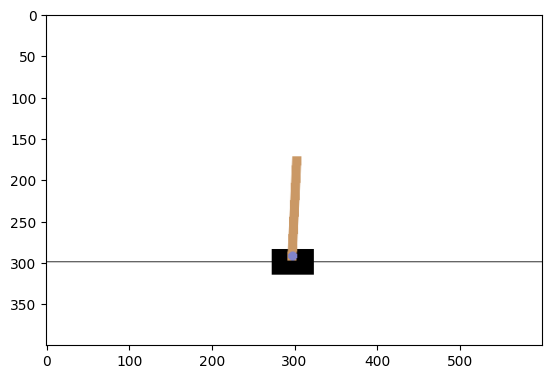

In [5]:
env = gym.make('CartPole-v1',render_mode = 'rgb_array')
state,info = env.reset()
plt.imshow(env.render())

In [6]:
class ReplayBuffer():
    def __init__(self,max_capacity = 2000,batch_size = 4):
        self.max_capacity = max_capacity
        self.buffer = deque(maxlen=max_capacity)
        self.batch_size = batch_size
        
    def add(self,state,action,reward,next_state,done):
        state = np.expand_dims(state,axis=0)
        next_state = np.expand_dims(next_state,axis=0)
        self.buffer.append([state,action,reward,next_state,done])
    def clear_histoy(self):
        self.buffer.clear()
        
    def get_batch(self):
        state,action,reward,next_state,done = zip(*random.sample(self.buffer,self.batch_size))
        return np.concatenate(state),action,reward,np.concatenate(next_state),done
    
    def __len__(self):
        return len(self.buffer)

In [67]:
class NoisyLayer(nn.Linear):
    def __init__(self, in_features,out_features,sigma_init = 0.1,bias = True):
        super(NoisyLayer,self).__init__(in_features,out_features,bias=bias)
        self.sigma_weight = nn.Parameter(torch.full((out_features,in_features),sigma_init))
        self.register_buffer('epsilon_weight',torch.zeros(out_features,in_features))
        if bias:
            self.sigma_bias = nn.Parameter(torch.full((out_features,),sigma_init))
            self.register_buffer('epsilon_bias',torch.zeros(out_features))
            
        self.reset_parameters()
        
    def reset_parameters(self):
        std = math.sqrt(3/self.in_features)
        self.weight.data.uniform_(-std,std)
        self.bias.data.uniform_(-std,std)
        
    def forward(self,x):
        self.epsilon_weight.normal_()
        bias = self.bias
        if bias is not None:
            self.epsilon_bias.normal_()
            bias = bias + self.sigma_bias * self.epsilon_bias
        return F.linear(x,self.weight + self.sigma_weight * self.epsilon_weight,bias)


In [68]:
class DQN(nn.Module):
    def __init__(self,n_actions,n_states):
        super(DQN,self).__init__()
        self.layer_1 = nn.Linear(n_states,64)
        self.n_layer_1 = NoisyLayer(64,64)
        self.n_layer_2 = NoisyLayer(64,n_actions)
    def forward(self,state):
        x = F.relu_(self.layer_1(state))
        x = F.relu_(self.n_layer_1(x))
        x = self.n_layer_2(x)
        return x.squeeze(dim=1)
    def reset_noise(self):
        self.n_layer_1.reset_noise()
        self.n_layer_2.reset_noise()
Q = DQN(2,4)

In [69]:
s = torch.from_numpy(state).unsqueeze(dim=0).unsqueeze(dim=0)

In [70]:
def select_action(state,epsilon = 1e-6):
    state = torch.from_numpy(state).unsqueeze(dim=0)
    action = torch.argmax(Q(state),dim=1)
    return action.item()

In [71]:
Q = DQN(2,4)
static_Q = DQN(2,4)
static_Q.load_state_dict(Q.state_dict())

<All keys matched successfully>

In [72]:
def train(Q,static_Q,num_time_steps,env,batch_size,replay_buffer_size = 2000,gamma = 0.99,lr = 1e-5):

    replay_buffer = ReplayBuffer(max_capacity=replay_buffer_size,batch_size=batch_size)
    optimizer = torch.optim.Adam(Q.parameters(),lr = lr)
    reward_per_t = []
    losses = []
    t_reward = 0
    state,info = env.reset()
    for t in range(1,num_time_steps):
        action = select_action(state)
        next_state,reward,done,_,info = env.step(action)
        replay_buffer.add(state,action,reward,next_state,done)
        state = next_state
        t_reward+=reward
        if done:
            state,info = env.reset()
            reward_per_t.append(t_reward)
            t_reward =0
        
        
        if len(replay_buffer) > 200:
            s,action,reward,n_s,done = replay_buffer.get_batch()
            s = torch.from_numpy(s).unsqueeze(dim=1).type(torch.float32)
            action = torch.tensor(action)
            reward = torch.tensor(reward)
            n_s = torch.from_numpy(n_s).unsqueeze(dim=1).type(torch.float32)
            
            not_done =torch.tensor(1-np.array(done))
            target = reward + not_done * (gamma * torch.max(static_Q(n_s).detach(),dim=1)[0])
            prediction = Q(s)
            prediction = prediction[range(len(action)),action]
            loss = torch.nn.functional.mse_loss(prediction,target,reduction='mean')
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            static_Q.load_state_dict(Q.state_dict())
            #static_Q.reset_noise()
            #Q.reset_noise()
        if np.mean(reward_per_t[-100:]) > env.spec.reward_threshold:
            print('Solved')
            break
        if t % 1000 == 0:
            plot(t,reward_per_t,losses)

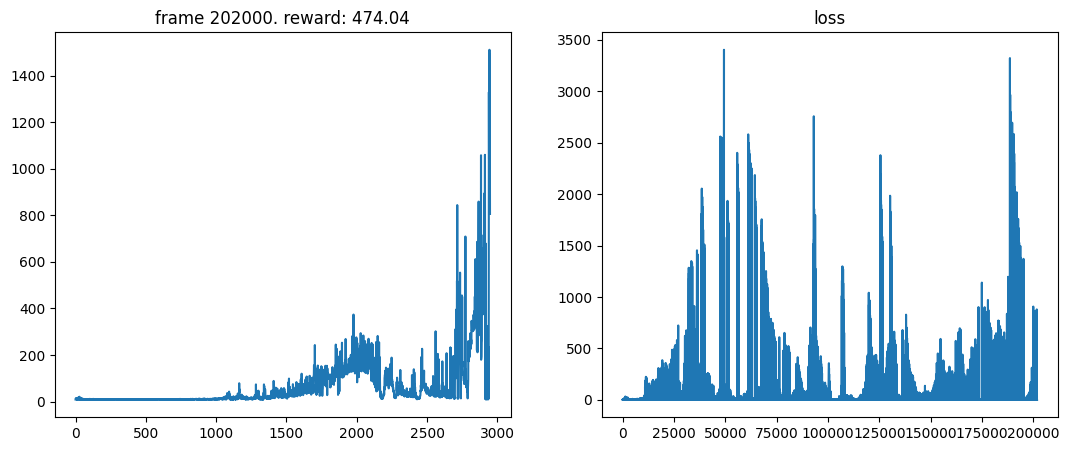

Solved


In [73]:
train(Q,static_Q,10000000,env,batch_size=4,replay_buffer_size=1000)